In [1]:
import os
import warnings
import random
import numpy as np
import torch

In [2]:
warnings.filterwarnings('ignore')

In [3]:
#====================Random seed====================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 100% deterministic
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [4]:
#====================Processing data====================
!wget https://github.com/richzhang/colorization/raw/caffe/colorization/resources/pts_in_hull.npy -O pts_in_hull.npy
ab_bins = torch.from_numpy(np.load("/kaggle/working/pts_in_hull.npy", allow_pickle=True)).to(torch.float32)
def soft_encode_ab(ab, topk=5, sigma=5.0):
    # ab: [H,W,2] float32, đơn vị ~[-128,127]
    H, W, _ = ab.shape
    ab_flat = ab.reshape(-1, 2)                                      # [H*W,2]
    dists = torch.cdist(ab_flat, ab_bins.to(ab.device))              # [N,Q]
    vals, idxs = torch.topk(dists, k=topk, largest=False, dim=1)
    w = torch.exp(-(vals**2) / (2*(sigma**2))); w = torch.softmax(w, dim=1)
    Z = torch.zeros((ab_flat.size(0), ab_bins.size(0)), device=ab.device)
    Z.scatter_(1, idxs, w)
    Z = Z.view(H, W, -1).permute(2,0,1).contiguous()                 # [Q,H,W]
    return Z

def soft_decode(z, T):
    zT = torch.softmax(torch.log(z + 1e-8)/T, dim=1)
    a = (zT * ab_bins[:,0][None,:,None,None]).sum(1)  # [B,H,W]
    b = (zT * ab_bins[:,1][None,:,None,None]).sum(1)  # [B,H,W]
    ab_hat = torch.stack([a, b], dim=1)        # [B,2,H,W]
    return ab_hat/128

--2025-10-06 01:58:17--  https://github.com/richzhang/colorization/raw/caffe/colorization/resources/pts_in_hull.npy
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/richzhang/colorization/caffe/colorization/resources/pts_in_hull.npy [following]
--2025-10-06 01:58:18--  https://raw.githubusercontent.com/richzhang/colorization/caffe/colorization/resources/pts_in_hull.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5088 (5.0K) [application/octet-stream]
Saving to: ‘pts_in_hull.npy’

pts_in_hull.npy     100%[===================>]   4.97K  --.-KB/s    in 0s      

2025-10-06 01:58:18 (52.1 MB/s)

In [5]:
#====================Dataset====================
import cv2
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

batch_size = 256

class dataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img, _ = self.data[idx]
        lab = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2LAB)   # uint8 Lab
        L  = lab[..., 0:1].astype(np.float32) / 255.0          # [0, 1]
        ab = lab[..., 1:3].astype(np.float32) - 128.0          # [-128,127]
        L, ab = torch.from_numpy(L).to(torch.float32), torch.from_numpy(ab).to(torch.float32)
        X, Z = L.permute(2, 0, 1), soft_encode_ab(ab)
        return X, Z

train_dataset = dataset(datasets.CIFAR10(root="./data", train=True, download=True))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count()-1, persistent_workers=True, prefetch_factor=4, pin_memory=True)
test_dataset = dataset(datasets.CIFAR10(root="./data", train=False, download=True))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

100%|██████████| 170M/170M [00:10<00:00, 16.1MB/s]


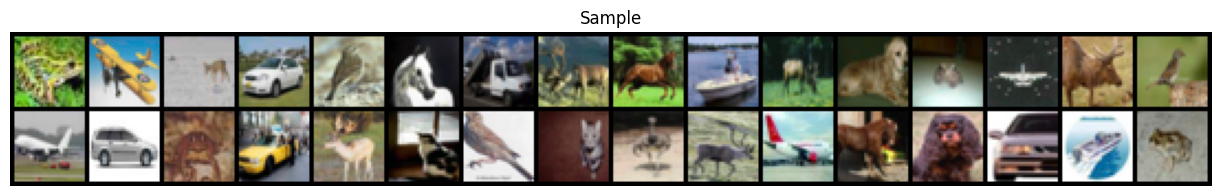

In [6]:
#====================Show data====================
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def unnormalize_image(L, ab):
    '''
    Input:
        L: Tensor of shape (B, 1, H, W), range [0, 1]
        ab: Tensor of shape (B, 2, H, W), range [-1, 1]
    Output:
        L: Tensor of shape (B, 1, H, W), range [0, 255]
        ab: Tensor of shape (B, 2, H, W), range [0, 255]
    '''
    return L *255, ab * 128 + 128

def imshow(L, ab, title):
    '''
    Input:
        L: Tensor of shape (B, 1, H, W), range [0, 255]
        ab: Tensor of shape (B, 2, H, W), range [0, 255]
        title: Title of the plot
    Output:
        Grid of 32 images in RGB format
    '''
    img = np.concatenate([L.numpy(), ab.numpy()], axis=1)
    img = img[:32, :, :, :]
    img = np.transpose(img, (0, 2, 3, 1))
    img = np.clip(np.rint(img), 0, 255).astype(np.uint8)
    img = [torch.from_numpy(cv2.cvtColor(img[i], cv2.COLOR_LAB2RGB)).permute(2, 0, 1) for i in range(len(img))] # conver lab to rgb
    img = torch.stack(img, dim=0)
    grid = make_grid(img, nrow=16, padding=2)
    
    plt.figure(figsize=(16,2))
    plt.imshow(grid.permute(1,2,0).numpy()) 
    plt.title(title)
    plt.axis('off')
    plt.show()

X, Z = next(iter(train_dataloader))
L, ab = unnormalize_image(X, soft_decode(Z, T=1))
imshow(L, ab, "Sample")

In [7]:
#====================Model====================
import torch.nn as nn
class ECCV16(nn.Module):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),
            nn.ReLU(True),
            norm_layer(64),
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),
            nn.ReLU(True),
            norm_layer(128),
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),
            nn.ReLU(True),
            norm_layer(256),
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            norm_layer(512),
        )
        
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2, bias=True),
            nn.ReLU(True),
            norm_layer(512),
        )
        
        self.block6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            norm_layer(512),
        )
        
        self.block7 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            norm_layer(256),
        )

        self.block8 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            norm_layer(128)
        )

        self.block9 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(64, 313, kernel_size=1, stride=1, padding=0, bias=True),  # logits Q=313
        )

    def forward(self, img):
        out = self.block1(img)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        out = self.block7(out)
        out = self.block8(out)
        out = self.block9(out)
        return out

In [8]:
#====================Shape check====================
test = ECCV16()
data, label = next(iter(train_dataloader))
test(data).shape, label.shape

(torch.Size([256, 313, 32, 32]), torch.Size([256, 313, 32, 32]))

In [9]:
#====================Compute weight====================
from scipy.ndimage import gaussian_filter1d

def color_weight(data, sigma = 5, lam = 0.5):
    p = torch.zeros(313)
    Q = len(p)
    
    for img, label in data:
        p += label.sum(dim=[0, 2, 3])
    
    # normalize input distribution
    p = p / p.sum()
    
    # smooth distribution with Gaussian kernel
    # (here 1D Gaussian filter, assuming p is already binned histogram)
    p_tilde = gaussian_filter1d(p, sigma=sigma)
    p_tilde = p_tilde / p_tilde.sum()
    mixed = (1 - lam) * p_tilde + lam / Q
    
    # take reciprocal
    w = 1.0 / mixed
    
    # normalize so expectation E[w] = 1 under p_tilde
    w = w / np.sum(p_tilde * w)
    w = torch.from_numpy(w)
    p_tilde = torch.from_numpy(p_tilde)
    return w
    
weight = color_weight(train_dataloader)

In [10]:
#====================Custom loss function====================
import torch.nn.functional as F

class RebalanceCEWithLogitsLoss(torch.nn.Module):
    def __init__(self, class_weights, eps = 1e-8):
        super().__init__()
        self.eps = eps
        self.register_buffer("w", torch.as_tensor(class_weights, dtype=torch.float32))

    def forward(self, logits, target):
        B, Q, H, W = logits.shape
        log_probs = F.log_softmax(logits, dim=1)  # (B,Q,H,W)
        q_star = target.argmax(dim=1)  # (B,H,W)
        ce_per_pixel = -(target * log_probs).sum(dim=1)  # (B,H,W)
        weights = self.w[q_star]  # (B,H,W)
        loss_per_pixel = weights * ce_per_pixel  # (B,H,W)

        return loss_per_pixel.sum() / (weights.sum() + self.eps)

In [11]:
#====================Training setup====================
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constant
EPOCHS = 200

# Model, optimizer, loss function
model = ECCV16().to(device)
criterion = RebalanceCEWithLogitsLoss(class_weights=weight).to(device)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-3, lr=1e-3)
device

device(type='cuda')

In [12]:
# ================== Train loop =================
train_logs = []
for epoch in range(EPOCHS+1):
    model.train()
    train_loss = test_loss = n_batches = 0
    for img, target in train_dataloader:
        img, target = img.to(device, non_blocking=True), target.to(device, non_blocking=True)
        optimizer.zero_grad()
        pred = model(img)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():  
        for img, target in test_dataloader:
            img, target = img.to(device), target.to(device)
            pred = model(img)
            loss = criterion(pred, target)
            test_loss += loss.item()
    train_logs.append(train_loss/len(train_dataloader))
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"Zhang_epoch_{epoch}.pth")
        print(f"Epoch: {epoch} | train_loss: {train_loss/len(train_dataloader):.6f} | test_loss: {test_loss/len(test_dataloader):.6f}")

Epoch: 0 | train_loss: 4.124916 | test_loss: 4.064769
Epoch: 10 | train_loss: 3.812783 | test_loss: 3.975753
Epoch: 20 | train_loss: 3.688276 | test_loss: 3.793160
Epoch: 30 | train_loss: 3.534430 | test_loss: 3.883168
Epoch: 40 | train_loss: 3.428404 | test_loss: 3.970939
Epoch: 50 | train_loss: 3.360058 | test_loss: 4.048384
Epoch: 60 | train_loss: 3.305699 | test_loss: 4.133248
Epoch: 70 | train_loss: 3.260726 | test_loss: 4.161262
Epoch: 80 | train_loss: 3.238988 | test_loss: 4.104245
Epoch: 90 | train_loss: 3.215810 | test_loss: 4.138566
Epoch: 100 | train_loss: 3.201431 | test_loss: 4.192346
Epoch: 110 | train_loss: 3.190769 | test_loss: 4.153902
Epoch: 120 | train_loss: 3.180085 | test_loss: 4.184864
Epoch: 130 | train_loss: 3.173260 | test_loss: 4.179245
Epoch: 140 | train_loss: 3.170146 | test_loss: 4.215255
Epoch: 150 | train_loss: 3.158759 | test_loss: 4.221409
Epoch: 160 | train_loss: 3.160782 | test_loss: 4.204435
Epoch: 170 | train_loss: 3.157265 | test_loss: 4.231643
Epo

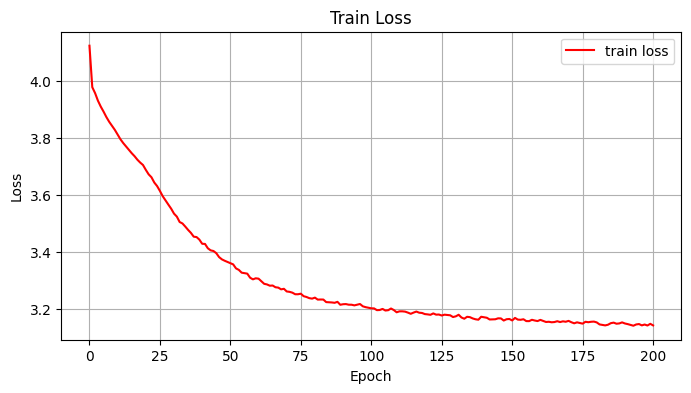

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

epochs = range(0, len(train_logs))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(epochs, train_logs, label="train loss", color="red")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Train Loss")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [14]:
#====================Load checkpoint====================
Zhang_50 = ECCV16().to(device)
Zhang_100 = ECCV16().to(device)
Zhang_150 = ECCV16().to(device)
Zhang_200 = ECCV16().to(device)

checkpoint = torch.load("Zhang_epoch_50.pth", map_location=device)
Zhang_50.load_state_dict(checkpoint)
checkpoint = torch.load("Zhang_epoch_100.pth", map_location=device)
Zhang_100.load_state_dict(checkpoint)
checkpoint = torch.load("Zhang_epoch_150.pth", map_location=device)
Zhang_150.load_state_dict(checkpoint)
checkpoint = torch.load("Zhang_epoch_200.pth", map_location=device)
Zhang_200.load_state_dict(checkpoint)

<All keys matched successfully>

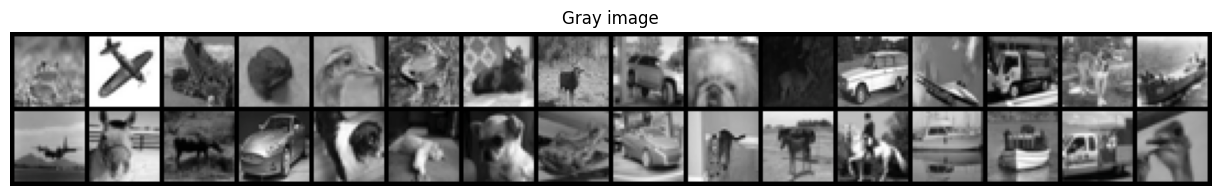

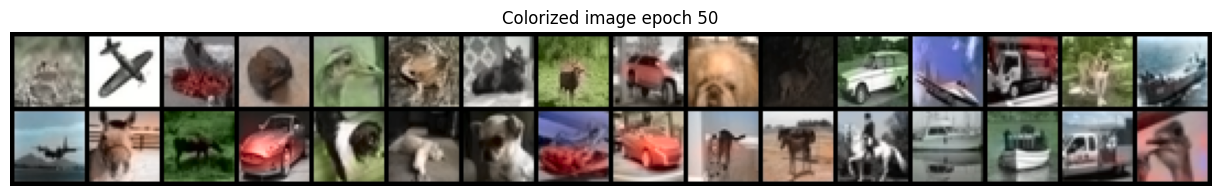

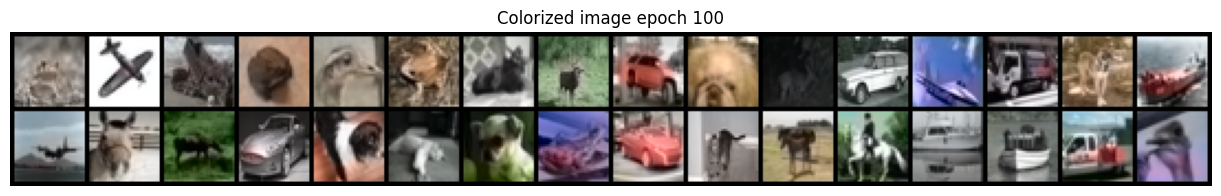

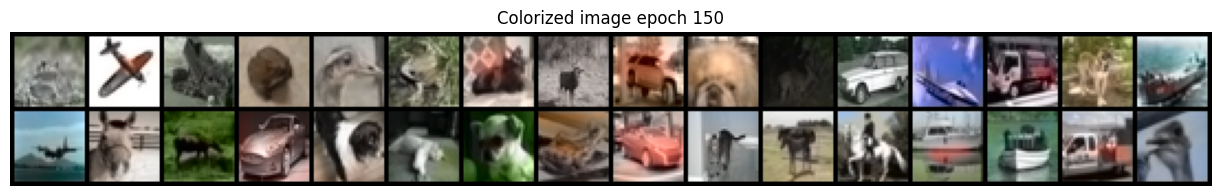

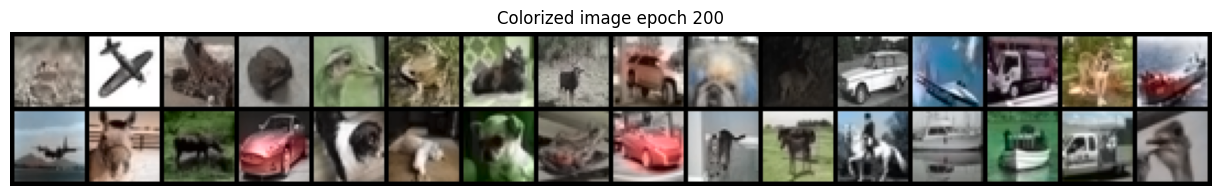

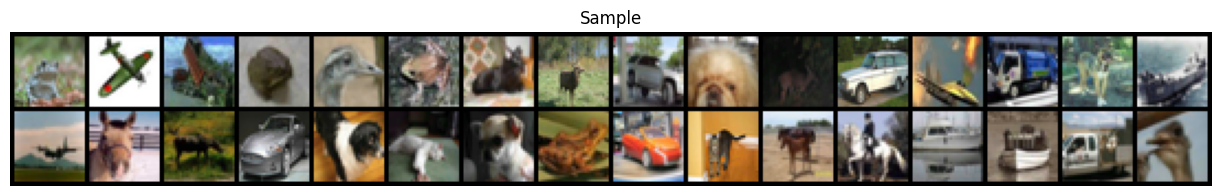

In [15]:
#====================Inference====================
with torch.no_grad():
    L, ab = next(iter(test_dataloader))
    # Show gray image
    B, C, H, W = L.shape
    imshow(L*255, torch.full((B, 2, H, W), 128, dtype=L.dtype), "Gray image")

    # Show colorized image
    L = L.to(device)
    ab_hat = torch.softmax(Zhang_50(L), dim=1)
    L, ab_hat = L.to("cpu"), ab_hat.to("cpu")
    L, ab_hat = unnormalize_image(L, soft_decode(ab_hat, T=0.38))
    imshow(L, ab_hat, "Colorized image epoch 50")

    # Show colorized image
    L = L.to(device)/255
    ab_hat = torch.softmax(Zhang_100(L), dim=1)
    L, ab_hat = L.to("cpu"), ab_hat.to("cpu")
    L, ab_hat = unnormalize_image(L, soft_decode(ab_hat, T=0.38))
    imshow(L, ab_hat, "Colorized image epoch 100")

    # Show colorized image
    L = L.to(device)/255
    ab_hat = torch.softmax(Zhang_150(L), dim=1)
    L, ab_hat = L.to("cpu"), ab_hat.to("cpu")
    L, ab_hat = unnormalize_image(L, soft_decode(ab_hat, T=0.38))
    imshow(L, ab_hat, "Colorized image epoch 150")

    # Show colorized image
    L = L.to(device)/255
    ab_hat = torch.softmax(Zhang_200(L), dim=1)
    L, ab_hat = L.to("cpu"), ab_hat.to("cpu")
    L, ab_hat = unnormalize_image(L, soft_decode(ab_hat, T=0.38))
    imshow(L, ab_hat, "Colorized image epoch 200")
    
    # Show orignal image
    L, ab = unnormalize_image(L/255, soft_decode(ab, T=1))
    imshow(L, ab, "Sample")